In [26]:
import pandas, numpy, matplotlib.pyplot as plt, seaborn, datetime

In [27]:
# Parametros Gerais 
seaborn.set(rc={'figure.figsize':(11, 4)})

In [28]:
# Parâmetros para dados

DATA_PATH = "../Data/all_month.csv"

relevantAttributes = ["depth","mag","latitude","longitude", "nst", "gap", "rms"]

FAULT_DATE          = "2020-04-12"
SAMPLING_FREQUENCY  = "90T" # 90 minutos
TIME_BEFORE_FAULT   = "7D"
TIME_AFTER_FAULT    = "1D"

# Parâmetros para o gráfico
COLORMAP_BEFORE_FAULT = "Greens"
LINE_ALPHA = 0.7

In [29]:
# Processa os dias de interesse
faultDate = pandas.to_datetime("2020-04-12")
startDate = faultDate - pandas.to_timedelta(TIME_BEFORE_FAULT)
endDate   = faultDate + pandas.to_timedelta(TIME_AFTER_FAULT)

#print(startDate,faultDate,endDate)

In [30]:
# Carrega dados
df = pandas.read_csv(DATA_PATH)

In [31]:
# Organização dados
df.time = pandas.to_datetime(df.time)
df.set_index('time', inplace=True)
df.sort_index(inplace=True)
df = df[relevantAttributes]

In [32]:
def pythonDatetimeToString(datetimeValue):
    return datetimeValue.strftime("%Y-%m-%d %H:%M:%S")
def pandasDatetimeToString(datetimeValue):
    return datetimeValue.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")


In [33]:
#df.loc['2020-04'].plot(subplots=True)
resampledDf = df[startDate.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S"):endDate.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")].resample(SAMPLING_FREQUENCY).mean()
# resampledDf.plot(subplots=True)

In [34]:
# Cria uns Fake outlier
resampledDf[pandasDatetimeToString(faultDate):]["mag"]=resampledDf[pandasDatetimeToString(faultDate):]["mag"]+2
resampledDf[pandasDatetimeToString(faultDate):]["depth"]=resampledDf[pandasDatetimeToString(faultDate):]["depth"]-15

#resampledDf.shape
#resampledDf.plot(subplots=True)

In [35]:
# Escalona valores de 0 a 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
resampledDf[resampledDf.columns] = scaler.fit_transform(resampledDf[resampledDf.columns])
#resampledDf.plot(subplots=True)

In [36]:
y  = resampledDf.values
x = [a for a in range(0,len(resampledDf.columns))]


In [38]:
import math, matplotlib.colors as colors

def createColormapSequence(colormap, baseList, outliersCount):
    norm = colors.Normalize(vmin=min(baseList), vmax=max(baseList))
    lineColor = [colormap(norm(x)) for x in baseList]

    lineColor+= [(1,0,0,1)]*outliersCount
    return [norm,lineColor]

#quantas cores sao necessarias
instancesBeforeFault = len(resampledDf[:faultDate])-1 # -1 porque considera eh <=
instancesAfterFault  = len(resampledDf[faultDate:])

#colormap para antes da falha
colormapBeforeFault = plt.get_cmap(COLORMAP_BEFORE_FAULT)

# valores base para as cores
logScale = [math.log10(x) for x in range(1,instancesBeforeFault+1)]
linearScale = [x/(instancesBeforeFault+1) for x in range(1,instancesBeforeFault+1)]


#
logColormap    = createColormapSequence(colormapBeforeFault,logScale,   instancesAfterFault)
linearColormap = createColormapSequence(colormapBeforeFault,linearScale,instancesAfterFault)


In [39]:
import matplotlib.cm as cm

def plotPcp(dataframe,lineColor,ax=None):
    
    if ax is None:
        # cria a figura 
        fig = plt.figure()
        ax = plt.gca()

    x = [a for a in range(0,len(dataframe.columns))]

    # Eixos verticais
    for i in x:
        ax.axvline(i, linewidth=1, color='black')

    # Nome/posição dos atributos nos eixos
    ax.set_xticks(x)
    ax.set_xticklabels(relevantAttributes)

    # Remove marcações no eixo Y
    ax.set_yticks([])

    # Remove margens
    ax.set_xlim(x[0], x[-1])

    for i in range(len(y)):
        ax.plot(x,dataframe.iloc[i],color=lineColor[i])

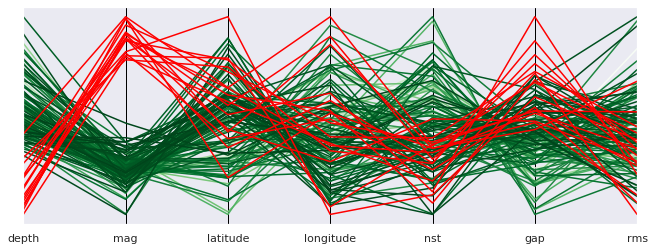

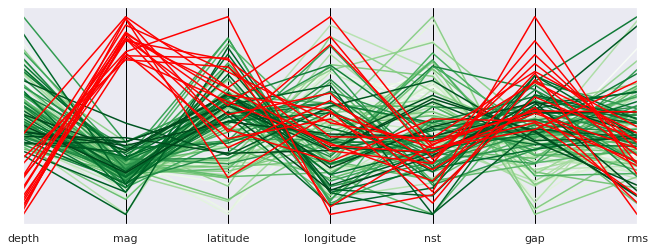

In [40]:
plotPcp(resampledDf,logColormap[1])
plotPcp(resampledDf,linearColormap[1])


In [ ]:
COLORMAP_SAMPLE_RATE = .15
colormapRate = int(len(lineColor)/(COLORMAP_SAMPLE_RATE*100))

[i for i in range(0, len(lineColor), colormapRate)]
#array1 = [lineColor[i] for i in range(0, len(lineColor), colormapRate)]
#array1

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Colorm1 = plt.get_cmap(COLORMAP_BEFORE_FAULT)
# lineColor = [Colorm1(norm(x)) for x in colorscale]

#cmap = mpl.cm.cool
#norm = mpl.colors.Normalize(vmin=5, vmax=10)
Colorm1.set_over('red')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=Colorm1),
             cax=ax, orientation='horizontal', label='Some Units',
             extend='max', extendfrac=.2)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 2))
rgb_array = [(i[0]*255,i[1]*255,i[2]*255) for i in linearColormap[1]]


dateTicksBefore = np.linspace(0, instancesBeforeFault, num=int(instancesBeforeFault*XTICKS_DENSITY))
dateTicksAfter = np.linspace(instancesBeforeFault, instancesBeforeFault+instancesAfterFault-1, num=int(instancesAfterFault*XTICKS_DENSITY))

dateTicks = numpy.append(dateTicksBefore,dateTicksAfter)
dateTicks.astype(int)


img = np.array(rgb_array, dtype=int).reshape((1, len(rgb_array), 3))
ax.imshow(img, aspect='auto', interpolation='nearest')
ax.grid(False)

ax.set_yticks([])
ax.set_xticks(dateTicks)
#ax.set_xticklabels(resampledDf.iloc[teste].index)
ax.set_xticklabels(resampledDf.iloc[dateTicks].index, rotation=+90, ha="center")

plt.show()

In [ ]:
def plotVerticalColorbar(labels, lineColor, elementsBeforeFault, elementsAfterFault,ax):

    #fig, ax = plt.subplots(figsize=(2,18))
    # Converte de percentual de RGB para RGB
    rgb_array = [(i[0]*255,i[1]*255,i[2]*255) for i in lineColor]

    # Alinhamento na vertical  
    verticalAlignedData = numpy.reshape(img,(128,1,3))[::-1]

    # Plota
    ax.imshow(verticalAlignedData, extent=[0, 1, 0, len(rgb_array)], aspect='auto')
    
    # remove grid 
    ax.grid(False)

    # Sem labels na horizontal
    ax.set_xticks([])

    # Labels na vertical

    dateTicksBefore = np.linspace(0, instancesBeforeFault, num=int(instancesBeforeFault*XTICKS_DENSITY))
    dateTicksAfter = np.linspace(instancesBeforeFault, instancesBeforeFault+instancesAfterFault-1, num=int(instancesAfterFault*XTICKS_DENSITY))

    dateTicks = numpy.append(dateTicksBefore,dateTicksAfter)
    dateTicks = dateTicks.astype(int)

    ax.set_yticks(dateTicks)
    ax.set_yticklabels(numpy.take(labels,dateTicks), rotation=0, ha="left",va = 'center', minor=False)
    # Labels do lado direito da figura    
    ax.yaxis.tick_right()


In [ ]:
resampledDf.iloc[teste].index

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure()
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[5, 1])

ax0 = fig.add_subplot(spec[0])
plotPcp(resampledDf,linearColormap[1],ax0)

ax1 = fig.add_subplot(spec[1])
plotVerticalColorbar(resampledDf.index.values,linearColormap[1], instancesBeforeFault, instancesAfterFault, ax1)

plt.show()

In [ ]:
dateTicksBefore = np.linspace(0, instancesBeforeFault, num=int(instancesBeforeFault*XTICKS_DENSITY))
dateTicksAfter = np.linspace(instancesBeforeFault, instancesBeforeFault+instancesAfterFault-1, num=int(instancesAfterFault*XTICKS_DENSITY))

dateTicks = numpy.append(dateTicksBefore,dateTicksAfter)
dateTicks = dateTicks.astype(int)
resampledDf.index.values[dateTicks]
